In [105]:
import numpy as np
import cv2
from tkinter import Tk, filedialog
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import PIL.Image
import pytesseract
#import keras_ocr

import matplotlib.pyplot as plt

In [2]:
def initiate_tk_dialog():
    root = Tk()  # pointing root to Tk() to use it as Tk() in program.
    root.withdraw()  # Hides small tkinter window.
    root.attributes('-topmost', True)  # Opened windows will be active. above all windows despite of selection.
    return root

def get_data_file(title: str, as_path = False):
    root = initiate_tk_dialog()
    if as_path == True:
        data_file: Path = Path(filedialog.askopenfilename(title= title))  # Returns opened path as str
    else:
        data_file: str = str(filedialog.askopenfilename(title= title)) 
    root.destroy()
    return data_file

def get_directory(title: str, as_path = False):
    root = initiate_tk_dialog()
    if as_path == True:
        directory: Path = Path(filedialog.askdirectory(title= title))
    else:
        directory: str = str(filedialog.askdirectory(title= title))
    root.destroy()
    return directory

In [122]:
def get_directory_files(file_extension: str):
    directory = get_directory('Select Images Directory', as_path=False)
    onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
    files = list([])
    for i in onlyfiles:
         if i.endswith(file_extension):
                file_path = '/'.join([directory, file])
                files.append(file_path)
    return directory, files

In [123]:
directory, files = get_directory_files(file_extension='.tiff')

In [100]:
#get_data_file('Get Image', as_path=False)
img_path = get_data_file('Select Image File', as_path=False) #r'C:\Users\SaANTIAGO\Google Drive Streaming\My Drive\18_UT_RAPID\cuttings_sensor\img\Upscale_Test\upscale_test_log_frame_1.tiff'

In [101]:
img = img_path #get_data_file('Get Image', as_path=False)
img = PIL.Image.open(img)
img.info

{'compression': 'tiff_lzw', 'dpi': (1, 1), 'resolution': (1, 1)}

In [102]:
img = img_path #get_data_file('Get Image', as_path=False)
img = PIL.Image.open(img)#.convert("L") #Convert to gray-scale
img = ImageOps.invert(img) #Invert
# size_factor = 3 #Size factor to resize image
# img = img.resize((img.size[0] * size_factor, img.size[1] * size_factor)) #Resize image

curr_sharpness = ImageEnhance.Sharpness(img)
new_sharpness = 2

# Sharpness enhanced by a factor of 8.3
img_sharped = curr_sharpness.enhance(new_sharpness)
  
# # shows updated image in image viewer
# #img_sharped

# img_sharped.show()

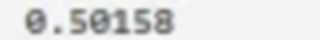

In [103]:
img

In [99]:
pytesseract.pytesseract.tesseract_cmd = Path(r'C:\Program Files\Tesseract-OCR\tesseract.exe')
txt = pytesseract.image_to_string(img,
                                   lang='eng',
                                   timeout=30,
                                 config='--psm 7 ') #-c tessedit_char_whitelist=0123456789.,-: ")
print(txt)

@.506619



In [145]:
img.save(r'C:\Users\SaANTIAGO\Google Drive Streaming\My Drive\18_UT_RAPID\cuttings_sensor\img\img.jpg')

In [127]:
# im1 = img.filter(ImageFilter.BLUR)

# im2 = img.filter(ImageFilter.MinFilter(3))
im3 = img.filter(ImageFilter.MedianFilter) 
im3.show()

### CV2

In [27]:
img = cv2.imread(img_path)
scale_percent = 500 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)#COLOR_BGR2HSV)
# h,s,v = cv2.split(HSV_img)
# v = cv2.GaussianBlur(v, (1,1), 0)
thresh = cv2.threshold(HSV_img, 0, 255, cv2.THRESH_OTSU)[1]
#cv2.imwrite('{}.png'.format(filename),thresh)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(1, 2))
#thresh = cv2.dilate(thresh, kernel)
# txt = pytesseract.image_to_string(thresh)#, config="--psm 6 digits")
# print(txt)
cv2.imshow('Show', thresh)
cv2.waitKey(0)

10

In [28]:
txt = pytesseract.image_to_string(thresh, timeout=15)#, config="--psm 7 -c tessedit_char_whitelist=0123456789,- ")
print(txt)

FSoRH, FRSP-BO-22 LO: 2B BG doo |B Betas



In [136]:
pipeline = keras_ocr.pipeline.Pipeline()
images = [keras_ocr.tools.read(img)]
# generate text predictions from the images
prediction_groups = pipeline.recognize(images)
predicted_image = prediction_groups[1]
for text, box in predicted_image:
    print(text)

NameError: name 'keras_ocr' is not defined

In [34]:
HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
thresh = cv2.threshold(HSV_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [47]:
df = pytesseract.image_to_data(img, output_type='data.frame')

In [48]:
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,750,33,-1.000000,NaN
1,2,1,1,0,0,0,2,6,688,24,-1.000000,NaN
2,3,1,1,1,0,0,2,6,688,24,-1.000000,NaN
3,4,1,1,1,1,0,2,6,688,24,-1.000000,NaN
4,5,1,1,1,1,1,2,6,91,24,83.297653,"73606,"
5,5,1,1,1,1,2,132,6,156,18,64.726341,2622-66-22
6,5,1,1,1,1,3,308,6,190,18,88.043762,16:26:64:499
7,5,1,1,1,1,4,530,6,160,19,13.366486,6.86233643


In [21]:
img = cv2.imread(get_data_file('Get Image', as_path=False), cv2.IMREAD_UNCHANGED)


In [25]:
print('Original Dimensions : ',img.shape)
 
scale_percent = 200 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

Original Dimensions :  (11, 250, 3)
Resized Dimensions :  (22, 500, 3)


In [ ]:
txt = txt.split(sep='\n\n')

In [ ]:
empty_list = []
for n in txt:
    empty_list.append(n.split('\n'))

In [ ]:
empty_list

In [ ]:
img = get_data_file('Get Image', as_path=False)
img = cv2.imread("input_image.png", 0)
ret, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_OTSU)

In [ ]:
directory = get_directory('Select Save Directory', as_path= False)
filename = directory + '\output.png'
cv2.imwrite(filename, img[thresh])

In [ ]:
img_path = get_data_file('Select File', as_path= False)
img = cv2.imread(img_path)
convert_bin,grey_scale = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
grey_scale = 255-grey_scale
grey_graph = plt.imshow(grey_scale,cmap='gray')
plt.show()

In [ ]:
img_path = get_data_file('Select File', as_path= False)
getText(img_path)

In [ ]:
#Function to Extract Text
def TxtExtract(directory):
    """
    This function will handle the core OCR processing of images.
    """
    
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            text = pytesseract.image_to_string(Image.open(filepath), timeout=5)
            if not text:
                ex_txt.extend([[file, "blank"]])
            else:   
                ex_txt.extend([[file, text]])
                
    fol_nm = os.path.split(os.path.dirname(subdir))[-1]
    
    print(f"Text Extracted from the files in '{fol_nm}' folder & saved to list..")

In [ ]:
ex_txt = []   #list to store the extracted text
TxtExtract(directory)